In [101]:
import matplotlib.pyplot as plt
import pynpoint.core.dataio
from pynpoint import *
from scripts.mcmc import residuals_rdi
import numpy as np
import emcee
import os
from pynpoint.util.image import (
    create_mask,
    polar_to_cartesian,
)
from astropy.io import fits


In [102]:
fwhm = 4.*0.01225  # (arcsec)
cent_size = fwhm  # (arcsec)
edge_size = 3.  # (arcsec)
#extra_rot = -134.24  # (deg)
extra_rot = 0.0  # (deg)
aperture = 5.*0.01225  # (arcsec)
#pca_number = 5  # k band
pca_number = 14  # rdi H
psf_scaling = 7.94187*76.42

band = "H"
output_place = f'./output/{band}/'

working_place_in = f'./input/{band}/'

backend = emcee.backends.HDFBackend(
    os.path.join(working_place_in, "PynPoint_database.hdf5"),
    name=f'mcmc_pca_{pca_number:03.0f}_backend',
    read_only=False,
)

ndim = 3    # sep, ang (pa), mag

samples = backend.get_chain()


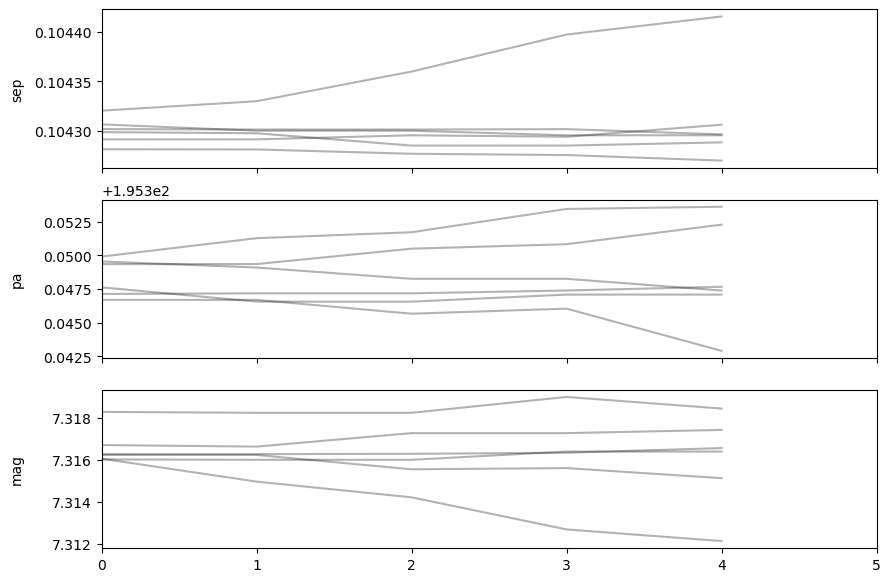

In [103]:
# plot initial chain
fig, axes = plt.subplots(ndim, figsize=(10,7), sharex=True)
labels = ['sep', 'pa', 'mag']

for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)



In [104]:
burnin = int(0.2 * samples.shape[0])
samples = samples[burnin:, :, :].reshape((-1, ndim))

sep_percen = np.percentile(samples[:, 0], [16.0, 50.0, 84.0])
ang_percen = np.percentile(samples[:, 1], [16.0, 50.0, 84.0])
mag_percen = np.percentile(samples[:, 2], [16.0, 50.0, 84.0])

print("Median and uncertainties (20% removed as burnin):")

print(
    f"Separation (mas) = {1e3*sep_percen[1]:.2f} "
    f"(-{1e3*sep_percen[1]-1e3*sep_percen[0]:.2f} "
    f"+{1e3*sep_percen[2]-1e3*sep_percen[1]:.2f})"
)

print(
    f"Position angle (deg) = {ang_percen[1]:.2f} "
    f"(-{ang_percen[1]-ang_percen[0]:.2f} "
    f"+{ang_percen[2]-ang_percen[1]:.2f})"
)

print(
    f"Contrast (mag) = {mag_percen[1]:.2f} "
    f"(-{mag_percen[1]-mag_percen[0]:.2f} "
    f"+{mag_percen[2]-mag_percen[1]:.2f})"
)


Median and uncertainties (20% removed as burnin):
Separation (mas) = 104.30 (-0.01 +0.02)
Position angle (deg) = 195.35 (-0.00 +0.00)
Contrast (mag) = 7.32 (-0.00 +0.00)


In [105]:
# plot residuals
pipeline = Pypeline(working_place_in, './', output_place)

images = pipeline.get_data(f'science_crop_tc_masked')
ref_data = pipeline.get_data(f'ref_crop_tc_masked')
psf = pipeline.get_data(f'flux_crop_mean')
parang = np.array(pipeline.list_attributes('science')['PARANG'])
pixscale = pipeline.list_attributes('science')['PIXSCALE']

im_shape = images.shape[-2:]
print("imshape", im_shape)
mask = create_mask(im_shape[-2:], (cent_size, edge_size))
print(parang, pixscale)
pipeline.run()


PynPoint v0.11.0

Working place: ./input/H/
Input place: ./
Output place: ./output/H/

Database: ./input/H/PynPoint_database.hdf5
Configuration: ./input/H/PynPoint_config.ini

Number of CPUs: 16
Number of threads: not set

-----------------------------
Attribute overview of science
-----------------------------

Static attributes:

   - PIXSCALE = 0.01225

Non-static attributes:

   - FILES = [b'./input/H/sci.fits']

   - INDEX = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]

   - NFRAMES = [48]

   - PARANG = [-88.43361300287415, -88.88420060776635, -89.32008318229879, -89.7551380430906, -90.1935100705823, -90.6121540206833, -91.01742237768019, -91.42099490009593, -91.83356915483682, -92.2223061050106, -92.59338763135236, -92.9681525655385, -93.34627331698562, -93.70739312222554, -94.05212335614408, -94.40036208056028, -99.66562590702517, -99.9128955

In [106]:
residual_im = residuals_rdi(np.array([sep_percen[1], ang_percen[1], mag_percen[1]]), images, ref_data,
                            psf, mask, parang, psf_scaling, pixscale, pca_number,
                            0.0, "mean")


fits.writeto(f"output/{band}/mcmc_residuals_test.fits", residual_im, overwrite=True)

(1, 199, 199)


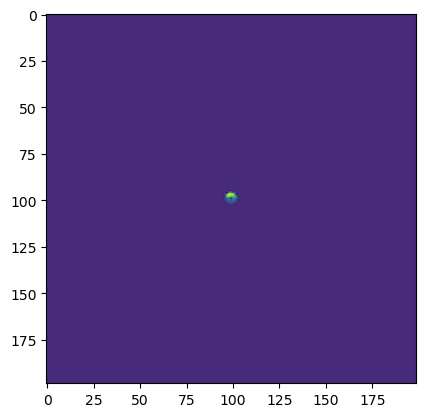

In [99]:

print(residual_im.shape)
plt.imshow(residual_im[0])